# Idiomicity model

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append("../")

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

In [3]:
from MWE2019.utils import tqdm
from MWE2019.materials import Materials
from MWE2019 import features
from MWE2019.utils import get_cache_path, install_data_cache

In [4]:
SEED = 15652
np.random.seed(SEED)

In [5]:
materials = Materials()

Remove NGram frequency < 50: 3588 removed
QIE removed: 0
Idiom removed: 3588
Character count before removal: 12883
Character count after removal: 2824
Remove character not in ngrams: 10059 removed
load CwnNodeVec from cache:  ..\MWE2019\..\data\cache_cwn_node_vec\cwn_node_vec_homophily.pkl
load variations from  E:\LangOn\MWE2019\data\cache_ngrams_list\ngrams_vars_samples.csv
Load QIE proper:  E:\LangOn\MWE2019\data\qie_list\qie_proper.csv


In [6]:
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

In [7]:
y = np.array(features.get_tags(materials))
np.unique(y, return_counts=True)

(array(['idiom', 'qie'], dtype='<U5'), array([1518, 2478], dtype=int64))

##  Baseline: Random features

In [8]:
rs = np.random.RandomState(15562)
X = rs.randn(len(y), 1)
train_accs, test_accs = [], []
for train_idx, test_idx in kf.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    std = StandardScaler()
    svm = SVC(gamma='auto')
    std_svm0 = Pipeline([('std', std), ('svm', svm)])
    std_svm0.fit(X_train, y_train)
    train_accs.append(std_svm0.score(X_train, y_train))
    test_accs.append(std_svm0.score(X_test, y_test))
print(f"training acc: {np.mean(train_accs)}({np.std(train_accs)})")
print(f"testing acc: {np.mean(test_accs)}({np.std(test_accs)})")

training acc: 0.620120356889653(0.003310251156456808)
testing acc: 0.6201239048811014(0.013239739768254306)


## Idiomaticity Model

## Feature 1: Usage Variation

In [9]:
vars_feats = [(materials.variations[ng]+1)/(materials.ngFreq[ng]*0.05) 
              for ng in chain(materials.qies, materials.idioms)]
vars_feats = np.log(np.array(vars_feats))

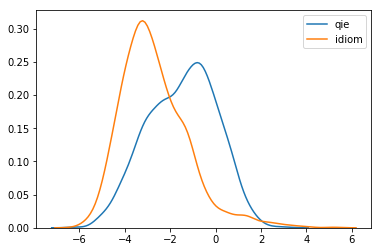

In [10]:
qie_vars = [x for x, tag in zip(vars_feats, y) if tag == "qie"]
idiom_vars = [x for x, tag in zip(vars_feats, y) if tag == "idiom"]
sns.distplot(qie_vars, label='qie', hist=False, kde=True)
sns.distplot(idiom_vars, label='idiom', hist=False, kde=True)

## Feature 2. Compound model (with M-Vectors)

In [11]:
feat_path = get_cache_path('model_features', 'features.pkl')
USE_CACHE = True
if USE_CACHE:
    with open(feat_path, "rb") as fin:
        comp_feats, composite_feats, vars_feats = pickle.load(fin)

In [12]:
if not USE_CACHE:
    comp_feats = features.make_compoundness_feature(materials)

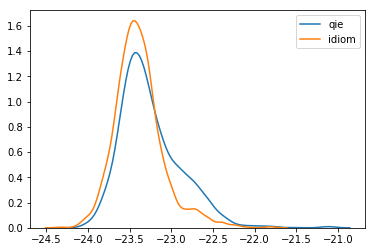

In [13]:
qie_comp = [x for x, tag in zip(comp_feats, y) if tag == "qie"]
idiom_comp = [x for x, tag in zip(comp_feats, y) if tag == "idiom"]
sns.distplot(qie_comp, label='qie', hist=False, kde=True)
sns.distplot(idiom_comp, label='idiom', hist=False, kde=True)


In [14]:
X = np.vstack([comp_feats]).transpose()
train_accs, test_accs = [], []
for train_idx, test_idx in kf.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    std = StandardScaler()
    svm = SVC(gamma='auto')
    std_svm1 = Pipeline([('std', std), ('svm', svm)])
    std_svm1.fit(X_train, y_train)
    train_accs.append(std_svm1.score(X_train, y_train))
    test_accs.append(std_svm1.score(X_test, y_test))
print(f"training acc: {np.mean(train_accs)}({np.std(train_accs)})")
print(f"testing acc: {np.mean(test_accs)}({np.std(test_accs)})")

training acc: 0.6229983874901492(0.0038102547418132765)
testing acc: 0.6221270337922403(0.0137490653568878)


## Feature 3. Composition model (with M-Vector + S-Vector)

In [15]:
if not USE_CACHE:
    composite_feats = features.make_compositioness_feature(materials)

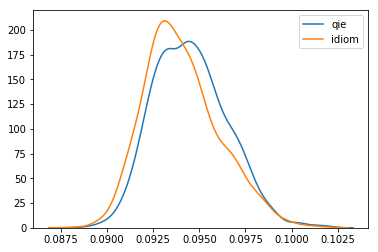

In [16]:
qie_composite = [x for x, tag in zip(composite_feats, y) if tag == "qie"]
idiom_composite = [x for x, tag in zip(composite_feats, y) if tag == "idiom"]
sns.distplot(qie_composite, label='qie', hist=False, kde=True)
sns.distplot(idiom_composite, label='idiom', hist=False, kde=True)

In [17]:
X = np.vstack([comp_feats, composite_feats]).transpose()
y = np.array(features.get_tags(materials))
train_accs, test_accs = [], []
for train_idx, test_idx in kf.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    std = StandardScaler()
    svm = SVC(gamma='auto')
    std_svm2 = Pipeline([('std', std), ('svm', svm)])
    std_svm2.fit(X_train, y_train)
    train_accs.append(std_svm2.score(X_train, y_train))
    test_accs.append(std_svm2.score(X_test, y_test))
print(f"training acc: {np.mean(train_accs)}({np.std(train_accs)})")
print(f"testing acc: {np.mean(test_accs)}({np.std(test_accs)})")

training acc: 0.6418922347021985(0.004736201865691002)
testing acc: 0.6358914267834794(0.019583799388876545)


In [18]:
install_data_cache('model_features')
feat_path = get_cache_path('model_features', 'features.pkl')
with open(feat_path, "wb") as fout:
    pickle.dump((comp_feats, composite_feats, vars_feats), fout)

## Scatter of three features

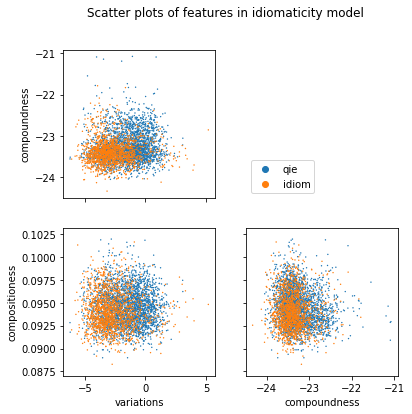

In [19]:
fig, axes = plt.subplots(2,2)
fig.suptitle("Scatter plots of features in idiomaticity model")
fig.set_size_inches(6,6)

sns.set_palette('tab10')
sns.scatterplot(x=vars_feats, y=comp_feats, hue=y, marker='o', linewidth=0, s=2, ax=axes[0][0])
sns.scatterplot(x=vars_feats, y=composite_feats, hue=y, marker='o', linewidth=0, s=2, ax=axes[1][0])
sns.scatterplot(x=comp_feats, y=composite_feats, hue=y, marker='o', linewidth=0, s=2, ax=axes[1][1])
sns.scatterplot(x=comp_feats, y=composite_feats, hue=y, marker='o', linewidth=0, s=0, ax=axes[0][1])

axes[0][1].axis('off')
axes[0][1].legend(loc="lower left")
axes[1][0].set_xlabel('variations')
axes[1][0].set_ylabel('compositioness')
axes[1][0].get_legend().remove()
axes[1][1].set_xlabel('compoundness')
axes[1][1].set_yticklabels([])
axes[1][1].get_legend().remove()
axes[0][0].set_ylabel('compoundness')
axes[0][0].set_xticklabels([])
axes[0][0].get_legend().remove()

In [20]:
scatter_path = get_cache_path('model_results', 'feature_scatters.png')
fig.savefig(scatter_path, dpi=150)

In [21]:
X = np.vstack([vars_feats, comp_feats, composite_feats]).transpose()
y = np.array(features.get_tags(materials))
train_accs, test_accs = [], []
for train_idx, test_idx in kf.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    std = StandardScaler()
    svm = SVC(gamma='auto')
    std_svm3 = Pipeline([('std', std), ('svm', svm)])
    std_svm3.fit(X_train, y_train)
    train_accs.append(std_svm3.score(X_train, y_train))
    test_accs.append(std_svm3.score(X_test, y_test))
print(f"training acc: {np.mean(train_accs)}({np.std(train_accs)})")
print(f"testing acc: {np.mean(test_accs)}({np.std(test_accs)})")

training acc: 0.7154034230307434(0.0053597326385368)
testing acc: 0.7079624530663329(0.014598037497347659)


## Label QIE sequences

In [22]:
USE_CACHE = True
if USE_CACHE:
    seq_path = get_cache_path('model_features', 'qie_seq_decode.pkl')
    with open(seq_path, "rb") as fin:
        (qie_decode, W) = pickle.load(fin)
else:
    W = features.get_linear_W(materials)
    qie_decode = []
    for qie_x in tqdm(materials.qies):
        senses_list = features.build_senses_sequences(qie_x, W, materials.charS)
        decode_seqs = features.beam_search_decoder(senses_list, 3)
        for decode_i, decode_state in enumerate(decode_seqs):
            decode_seq, decode_prob = decode_state
            qie_decode.append((qie_x, decode_i+1, *decode_seq))
    install_data_cache('model_features')
    seq_path = get_cache_path('model_features', 'qie_seq_decode.pkl')
    with open(seq_path, "wb") as fout:
        pickle.dump((qie_decode, W), fout)

In [23]:
qie_decode_df = pd.DataFrame.from_records(qie_decode, columns=["ngram", "topk", "sid_1", "sid_2", "sid_3", "sid_4"])
install_data_cache("model_results")
decode_path = get_cache_path('model_results', 'qie_seq_decode.csv')
qie_decode_df.to_csv(decode_path)

### Output ngram features CSV

In [24]:
ngram_feats = pd.DataFrame({
    "ngram": materials.qies + materials.idioms,
    "type": y, 
    "variations": vars_feats,
    "compound": comp_feats,
    "composite": composite_feats})
ngram_feats["exact_freq"] = [materials.ngFreq.get(x) for x in ngram_feats.ngram]
ngram_feats_path = get_cache_path('model_results', 'ngram_feats.csv')
ngram_feats.to_csv(ngram_feats_path)

### Output ngram features of standardized score

In [25]:
from scipy.stats import zscore
ngram_feats = pd.DataFrame({
    "ngram": materials.qies + materials.idioms,
    "type": y, 
    "variations": zscore(vars_feats),
    "compound": zscore(comp_feats),
    "composite": zscore(composite_feats)})
ngram_feats["exact_freq"] = [materials.ngFreq.get(x) for x in ngram_feats.ngram]
ngram_feats_path = get_cache_path('model_results', 'ngram_feats_z.csv')
ngram_feats.to_csv(ngram_feats_path)

## QIE Proper

In [26]:
feat_path = get_cache_path('model_features', 'features.pkl')
USE_CACHE = True
if USE_CACHE:
    with open(feat_path, "rb") as fin:
        comp_feats, composite_feats, vars_feats = pickle.load(fin)

In [27]:
propers = list(materials.proper_qie)

In [28]:
qie_generals = [x for x in materials.qies if x not in propers]
np.random.shuffle(qie_generals)
qie_generals = qie_generals[:len(propers)]

In [29]:
is_proper = ["proper"] * len(propers) + ["generic"] * len(qie_generals)
pr_qie_idx = []
for qie_x in chain(propers, qie_generals):
    pr_qie_idx.append(materials.qies.index(qie_x))

In [30]:
assert all(materials.qies[i] == qie_x for i, qie_x in zip(pr_qie_idx, chain(propers, qie_generals)))

In [31]:
pr_comp_feats = [comp_feats[idx] for idx in pr_qie_idx]
pr_composite_feats = [composite_feats[idx] for idx in pr_qie_idx]
pr_vars_feats = [vars_feats[idx] for idx in pr_qie_idx]

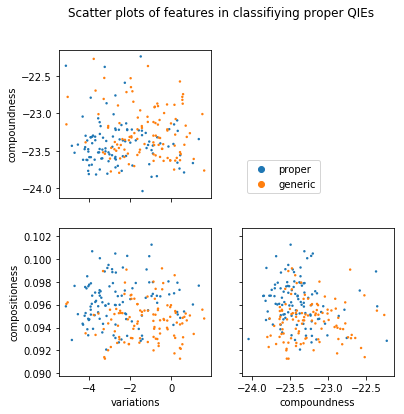

In [32]:
fig, axes = plt.subplots(2,2)
fig.suptitle("Scatter plots of features in classifiying proper QIEs")
fig.set_size_inches(6,6)

sns.set_palette('tab10')
sns.scatterplot(x=pr_vars_feats, y=pr_comp_feats, hue=is_proper, marker='o', linewidth=0, s=6, ax=axes[0][0])
sns.scatterplot(x=pr_vars_feats, y=pr_composite_feats, hue=is_proper, marker='o', linewidth=0, s=6, ax=axes[1][0])
sns.scatterplot(x=pr_comp_feats, y=pr_composite_feats, hue=is_proper, marker='o', linewidth=0, s=6, ax=axes[1][1])
sns.scatterplot(x=pr_comp_feats, y=pr_composite_feats, hue=is_proper, marker='o', linewidth=0, s=0, ax=axes[0][1])

axes[0][1].axis('off')
axes[0][1].legend(loc="lower left")
axes[1][0].set_xlabel('variations')
axes[1][0].set_ylabel('compositioness')
axes[1][0].get_legend().remove()
axes[1][1].set_xlabel('compoundness')
axes[1][1].set_yticklabels([])
axes[1][1].get_legend().remove()
axes[0][0].set_ylabel('compoundness')
axes[0][0].set_xticklabels([])
axes[0][0].get_legend().remove()

In [35]:
proper_scatter_path = get_cache_path('model_results', 'qie_proper_scatters.png')
fig.savefig(proper_scatter_path, dpi=150)

## Proper Classification: Baseline

In [33]:
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
rs = np.random.RandomState(15562)
pr_X = rs.randn(len(is_proper), 1)
pr_y = np.array(is_proper)
train_accs, test_accs = [], []
for train_idx, test_idx in kf.split(pr_X):
    X_train, X_test = pr_X[train_idx], pr_X[test_idx]
    y_train, y_test = pr_y[train_idx], pr_y[test_idx]
    std = StandardScaler()
    svm = SVC(gamma='auto')
    std_svm_pr = Pipeline([('std', std), ('svm', svm)])
    std_svm_pr.fit(X_train, y_train)
    train_accs.append(std_svm_pr.score(X_train, y_train))
    test_accs.append(std_svm_pr.score(X_test, y_test))
print(f"training acc: {np.mean(train_accs)}({np.std(train_accs)})")
print(f"testing acc: {np.mean(test_accs)}({np.std(test_accs)})")

training acc: 0.5405161984137653(0.021642710609430647)
testing acc: 0.4305496828752643(0.04766445614372366)


## Proper Classification: Idiomatic model

In [34]:
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
pr_X = np.vstack([pr_vars_feats, pr_comp_feats, pr_composite_feats]).transpose()
pr_y = np.array(is_proper)
train_accs, test_accs = [], []
for train_idx, test_idx in kf.split(pr_X):
    X_train, X_test = pr_X[train_idx], pr_X[test_idx]
    y_train, y_test = pr_y[train_idx], pr_y[test_idx]
    std = StandardScaler()
    svm = SVC(gamma='auto')
    std_svm_pr = Pipeline([('std', std), ('svm', svm)])
    std_svm_pr.fit(X_train, y_train)
    train_accs.append(std_svm_pr.score(X_train, y_train))
    test_accs.append(std_svm_pr.score(X_test, y_test))
print(f"training acc: {np.mean(train_accs)}({np.std(train_accs)})")
print(f"testing acc: {np.mean(test_accs)}({np.std(test_accs)})")

training acc: 0.7812542008334453(0.024041355934665724)
testing acc: 0.7038054968287526(0.06074831298696832)


## Note:
* Composite（值欲高代表意義組合不透明）: 本身是各個字的sense vector和QIE的SS distance，理論上距離愈大代表QIE的意義與各個字的組合差愈遠。值高（不透明）的四字格，很容易抓到四字人名，如「黛咪摩爾」、「凱莉米洛」、「諮商輔導」；值小（透明）的四字格有「感到憤怒」、「不亦樂乎」、「閱讀測驗」
* Compound（值愈小代表經常並列, D1）：是從構詞網絡推算出來的構詞組合機率，機率值愈高代表QIE中的這幾個字一起出現是愈可預期的（從構詞的角度而言）。值小（經常並列）的例子有「貪官汙吏」、「八卦雜誌」，值大的有「兄弟姊妹」、「尋尋覓覓」、「承認錯誤」